# Pedestrian Forecasting
***

## Preparation

We start by installing the packages we need.

Import packages.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Data preparation

## Exploratory Data Analysis

We now plot our weekly data.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import talib

real_df = pd.read_table('/projects/genomic-ml/da2343/ml_project_2/robust_algo_trader/data/EURUSD_H1_200702210000_202304242100.tsv')
# real_df = pd.read_table('/Users/newuser/Projects/robust-algo-trader/data/EURUSD_H1_202302010000_202304242100.tsv')

df = real_df.copy()
# take only last 7000 rows
df = df.iloc[-(200+24*7*4):]
# df = df.iloc[-120:]
# remove the following columns <TICKVOL>, <VOL> and <SPREAD>
df = df.drop(['<TICKVOL>', '<VOL>', '<SPREAD>'], axis=1)
df = df.rename(columns={'<DATE>': 'Date', 
                                '<TIME>': 'Time', 
                                '<OPEN>': 'Open', 
                                '<HIGH>': 'High', 
                                '<LOW>': 'Low', 
                                '<CLOSE>': 'Close'
                                })
# combine the date and time columns
df['Date_Time'] = df['Date'] + ' ' + df['Time']
# remove the date and time columns
df = df.drop(['Date', 'Time'], axis=1)
# convert the date_time column to datetime
df['Time'] = pd.to_datetime(df['Date_Time'])
# Rename Date_Time to Time
# df.index = df['Time']
# df.set_index("Time")
# remove the Time column
df = df.drop(['Time'], axis=1)


prices = df["Close"].values
df["SMA"] = talib.SMA(prices, timeperiod=200)
# df["EMA"] = talib.EMA(prices, timeperiod=200)
# df['TEMA'] = talib.TRIMA(prices, timeperiod=200*2)

# df['ATR'] = talib.NATR(df['High'], df['Low'], df['Close'], timeperiod=200)
# df["EMA"] = ema
df = df.dropna()
y = df[['SMA']]

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

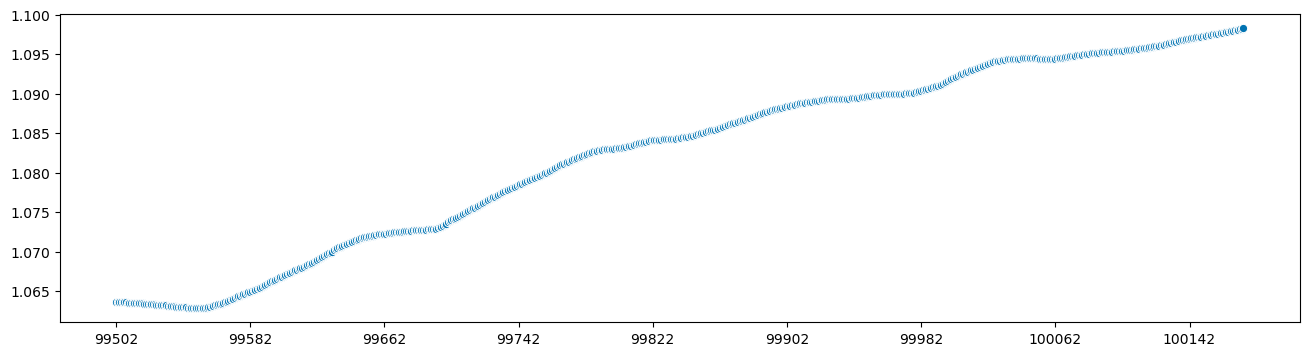

In [3]:
from sktime.utils.plotting import plot_series
plot_series(y)

## Forecasting

### Multiple Linear Regression

In [4]:
from sktime.forecasting.model_selection import temporal_train_test_split
y_train, y_test = temporal_train_test_split(y, test_size=24*7) # Predict from 1st July 2019

/projects/genomic-ml/da2343/cs685/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.150e-05, tolerance: 4.009e-06
  model = cd_fast.enet_coordinate_descent(


MAPE: 0.000976


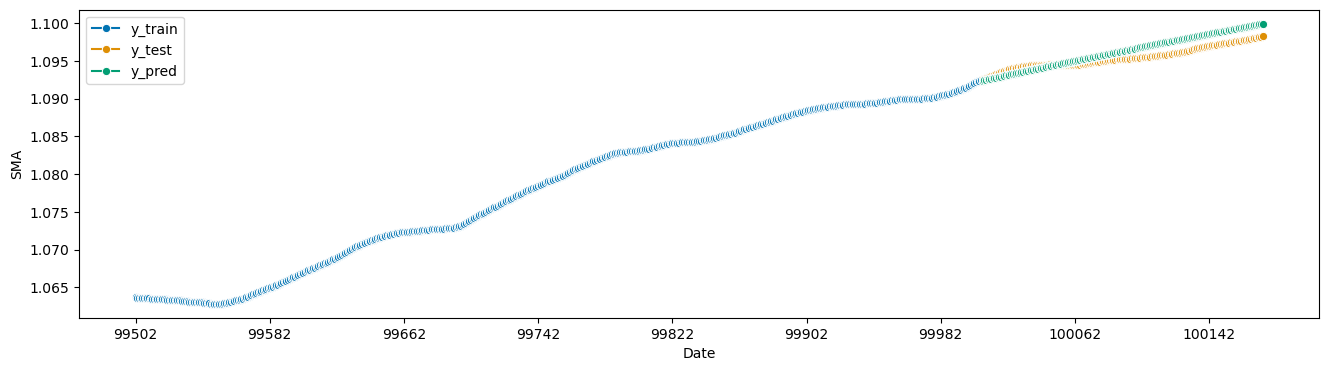

In [8]:
from sktime.forecasting.base import ForecastingHorizon
from sklearn.linear_model import LinearRegression, LassoCV
from sktime.forecasting.compose import make_reduction
from sktime.utils.plotting import plot_series
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

regressor = LassoCV()
forecaster = make_reduction(regressor, window_length=30, strategy="recursive")
forecaster.fit(y_train)
fh = ForecastingHorizon(y_test.index, is_relative=False)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"], x_label='Date', y_label='SMA')

print('MAPE: %.6f' % mean_absolute_percentage_error(y_test, y_pred, symmetric=False))

MAPE: 0.0042


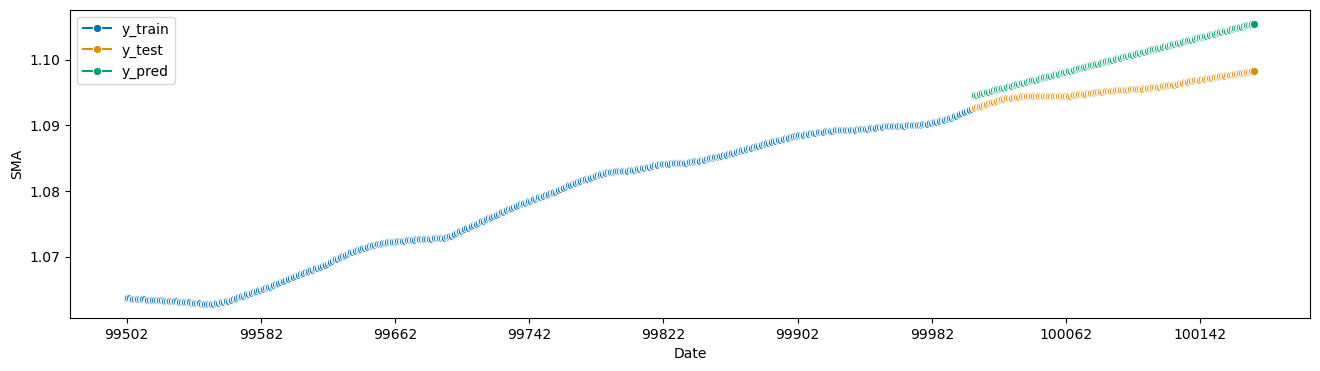

In [9]:
from sktime.datasets import load_airline
from sktime.forecasting.trend import TrendForecaster

forecaster = TrendForecaster()
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"], x_label='Date', y_label='SMA')
print('MAPE: %.4f' % mean_absolute_percentage_error(y_test, y_pred, symmetric=False))

In [ ]:
y_pred

0.004112990659965586

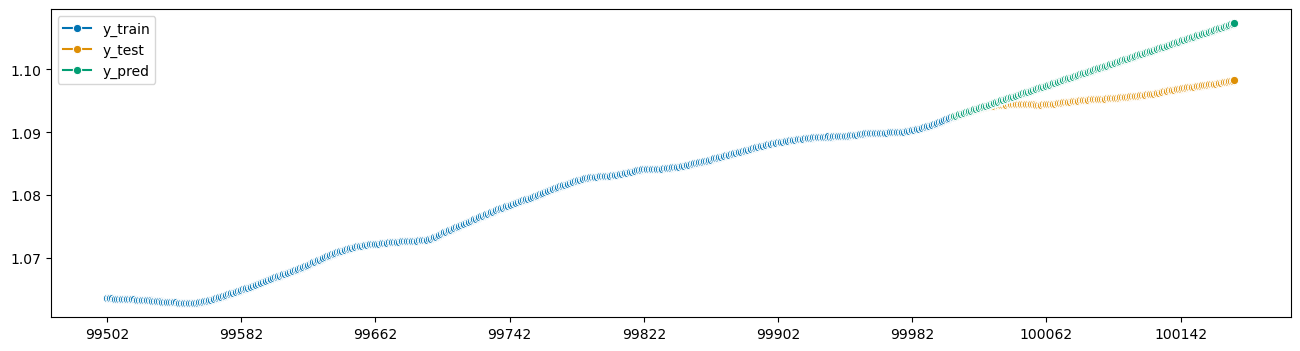

In [8]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

forecaster = ExponentialSmoothing(trend="add", seasonal="additive", sp=12)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

### XGBoost with multiple inputs

0.003285222163183654

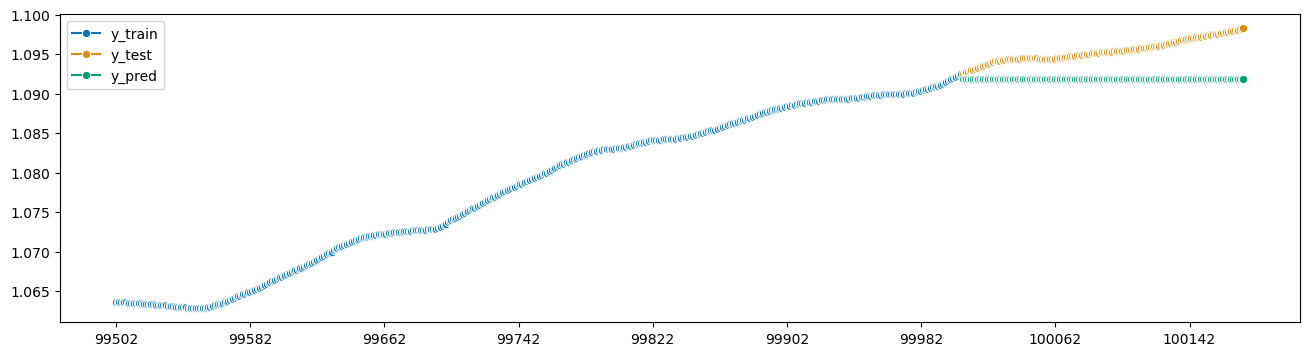

In [10]:
from xgboost import XGBRegressor

regressor = XGBRegressor(objective='reg:squarederror', random_state=42)
forecaster = make_reduction(regressor, window_length=30, strategy="recursive")
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

### Tuning the hyperparameters of our forecaster

0.0032797810522623163

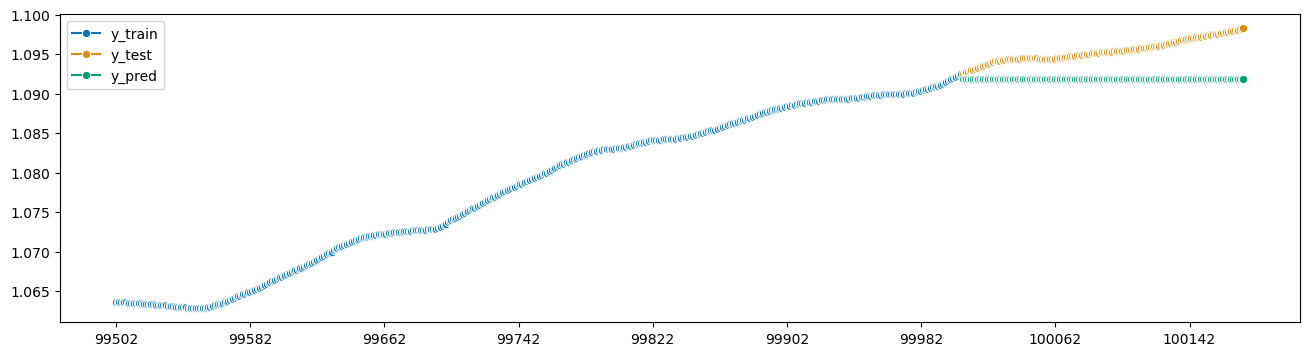

In [11]:
from sktime.forecasting.model_selection import SingleWindowSplitter
from sktime.forecasting.model_selection import ForecastingRandomizedSearchCV

validation_size = 26
cv = SingleWindowSplitter(window_length=len(y)-validation_size, fh=validation_size)


param_grid = {
    'estimator__max_depth': [3, 5, 6, 10, 15, 20],
    'estimator__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'estimator__subsample': np.arange(0.5, 1.0, 0.1),
    'estimator__colsample_bytree': np.arange(0.4, 1.0, 0.1),
    'estimator__colsample_bylevel': np.arange(0.4, 1.0, 0.1),
    'estimator__n_estimators': [100, 500, 1000]
}

regressor = XGBRegressor( random_state=42)
forecaster = make_reduction(regressor, window_length=52, strategy="recursive")
gscv = ForecastingRandomizedSearchCV(forecaster, cv=cv, param_distributions=param_grid, n_iter=100, random_state=42)
gscv.fit(y_train)
y_pred = gscv.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

In [12]:
gscv.cv_results_

,mean_test_MeanAbsolutePercentageError,mean_fit_time,mean_pred_time,params,rank_test_MeanAbsolutePercentageError
0,0.002504,0.616130,0.035424,"{'estimator__subsample': 0.5, 'estimator__n_es...",89.0
1,0.002439,0.228471,0.028162,"{'estimator__subsample': 0.5, 'estimator__n_es...",62.0
2,0.002379,0.218728,0.027884,"{'estimator__subsample': 0.5, 'estimator__n_es...",4.0
3,0.002449,0.066076,0.027900,"{'estimator__subsample': 0.6, 'estimator__n_es...",69.0
4,0.007068,0.339411,0.028075,"{'estimator__subsample': 0.8999999999999999, '...",91.5
...,...,...,...,...,...
95,0.002407,0.064791,0.027509,"{'estimator__subsample': 0.8999999999999999, '...",21.0
96,0.002408,0.062892,0.027491,"{'estimator__subsample': 0.7, 'estimator__n_es...",22.0
97,0.007142,0.307866,0.027872,"{'estimator__subsample': 0.7999999999999999, '...",96.0
98,0.002383,0.443686,0.028520,"{'estimator__subsample': 0.6, 'estimator__n_es...",7.0


## Adding components to our forecasting pipeline

0.002953376370366163

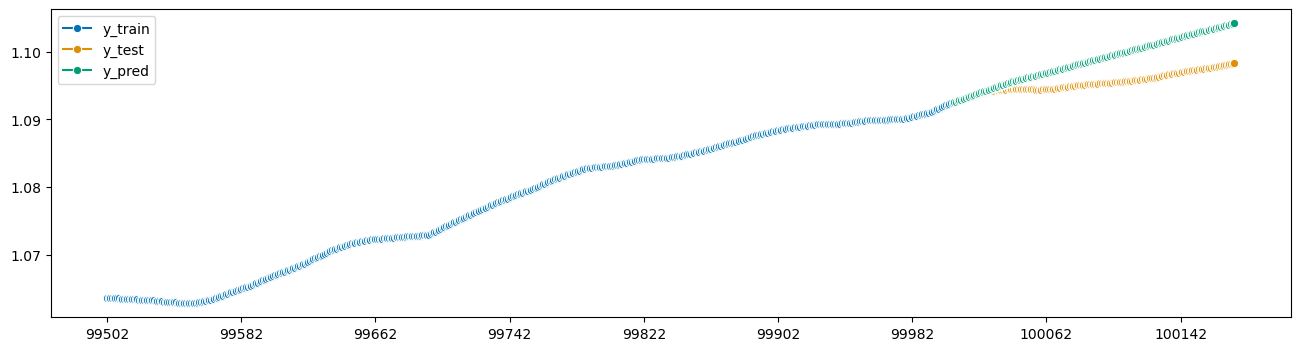

In [14]:
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.forecasting.trend import PolynomialTrendForecaster

regressor = XGBRegressor(objective='reg:squarederror', random_state=42)

forecaster = TransformedTargetForecaster(
    [
        ("deseasonalize", Deseasonalizer(model="multiplicative", sp=52)),
        ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
        ("forecast", make_reduction(regressor, window_length=52, strategy="recursive"),
        ),
    ]
)

param_grid = {
    'deseasonalize__model': ['multiplicative', 'additive'],
    'detrend__forecaster__degree': [1, 2, 3],
    'forecast__estimator__max_depth': [3, 5, 6, 10, 15, 20],
    'forecast__estimator__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'forecast__estimator__subsample': np.arange(0.5, 1.0, 0.1),
    'forecast__estimator__colsample_bytree': np.arange(0.4, 1.0, 0.1),
    'forecast__estimator__colsample_bylevel': np.arange(0.4, 1.0, 0.1),
    'forecast__estimator__n_estimators': [100, 500, 1000]
}

gscv = ForecastingRandomizedSearchCV(forecaster, cv=cv, param_distributions=param_grid, n_iter=100, random_state=42)
gscv.fit(y_train)
y_pred = gscv.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)